In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path

import arviz as az
import numpyro

from hbmep.config import Config
from hbmep.data_access import Dataset
from hbmep.models.rats.utils import load_data

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

import logging

import numpy as np
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

from hbmep.config import Config
from hbmep.models.baseline import Baseline
from hbmep.models.utils import Site as site

logger = logging.getLogger(__name__)


#### Load config

In [3]:
config = Config()

ROOT_PATH = Path(os.getcwd()).parent.parent.parent.absolute()
config.HERE = ROOT_PATH

#### Load data and preprocess

In [4]:
data = Dataset(config)

""" Load """
fpath = "/mount/hdd1/acute_mapping/proc"
dir_name = "physio"

dir = os.path.join(fpath, dir_name)

subjects = range(1, 9)
subdir_pattern = ["*J_RCML_000*"]

df, mat, time, auc_window = load_data(
    data=data, dir=dir, subjects=subjects, subdir_pattern=subdir_pattern
)

""" Custom filter """
columns = data.columns
sub = [
    ("amap06", "-C7L"),
    ("amap06", "-C8L"),
    ("amap06", "-C8L"),
    ("amap08", "C6M-C7L"),
    ("amap08", "C7M-C7L")
]
ind = df[columns].apply(tuple, axis=1).isin(sub)
# ind = (df.subject == "amap06") & (df.compound_position.isin(["-C7L", "-C8L"]))
# ind = (df.subject == "amap06")

df = df[ind].copy()
df.reset_index(drop=True, inplace=True)

mat = mat[ind, ...]

""" Preprocess """
df, encoder_dict, mat = data.build(df=df, mat=mat)

2023-07-05 15:23:17,691 - hbmep.data_access.core - INFO - Artefacts directory - /home/vishu/repos/hbmep/reports


2023-07-05 15:23:42,644 - hbmep.utils.utils - INFO - func:load_data took: 24.95 sec
2023-07-05 15:23:42,657 - hbmep.data_access.core - INFO - Processing data ...
2023-07-05 15:23:42,661 - hbmep.utils.utils - INFO - func:preprocess took: 0.00 sec
2023-07-05 15:23:42,661 - hbmep.utils.utils - INFO - func:build took: 0.00 sec


In [5]:
class RectifiedLogistic(Baseline):
    def __init__(self, config: Config):
        super(RectifiedLogistic, self).__init__(config=config)
        self.name = "Rectified_Logistic"

        self.x_space = np.linspace(0, 800, 2000)

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        with numpyro.plate("n_response", self.n_response, dim=-1):
            with numpyro.plate("n_subject", n_subject, dim=-2):
                """ Hyper-priors """
                a_mean = numpyro.sample(
                    site.a_mean,
                    dist.TruncatedNormal(150, 20, low=0)
                )
                a_scale = numpyro.sample(site.a_scale, dist.HalfNormal(20))

                b_scale = numpyro.sample(site.b_scale, dist.HalfNormal(0.5))

                h_scale = numpyro.sample("h_scale", dist.HalfNormal(5))
                v_scale = numpyro.sample("v_scale", dist.HalfNormal(50))

                lo_scale = numpyro.sample(site.lo_scale, dist.HalfNormal(0.05))

                with numpyro.plate("n_feature0", n_feature0, dim=-3):
                    """ Priors """
                    a = numpyro.sample(
                        site.a,
                        dist.TruncatedNormal(a_mean, a_scale, low=0)
                    )
                    b = numpyro.sample(site.b, dist.HalfCauchy(b_scale))

                    h = numpyro.sample("h", dist.HalfCauchy(h_scale))
                    v = numpyro.sample("v", dist.HalfCauchy(v_scale))

                    lo = numpyro.sample(site.lo, dist.HalfCauchy(lo_scale))

                    p = numpyro.sample("p", dist.HalfNormal(10))

                    gamma_scale_offset = numpyro.sample(
                        site.gamma_scale_offset, dist.HalfCauchy(20)
                    )
                    gamma_scale_slope = numpyro.sample(
                        site.gamma_scale_slope, dist.HalfCauchy(20)
                    )

        """ Model """
        mean = numpyro.deterministic(
            site.mean,
            lo[feature0, subject] + \
            jnp.maximum(
                0,
                -1 + \
                (h[feature0, subject] + 1) / \
                jnp.power(
                    1 + \
                    (jnp.power(1 + h[feature0, subject], v[feature0, subject]) - 1) * \
                    jnp.exp(-b[feature0, subject] * (intensity - a[feature0, subject])),
                    1 / v[feature0, subject]
                )
            )
        )
        scale = numpyro.deterministic(
            "scale",
            gamma_scale_offset[feature0, subject] + \
            gamma_scale_slope[feature0, subject] * jnp.power(1 / mean, p[feature0, subject])
        )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(mean * scale, scale).to_event(1),
                obs=response_obs
            )


model = RectifiedLogistic(config)
mcmc, posterior_samples = model.run_inference(df)
mcmc.print_summary(prob=.95)

# model = RectifiedLogistic(config)
# predictive_check(model, df);

2023-07-05 15:24:49,565 - hbmep.data_access.core - INFO - Artefacts directory - /home/vishu/repos/hbmep/reports
2023-07-05 15:24:49,569 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-07-05 15:24:49,569 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-07-05 15:24:49,570 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-07-05 15:24:49,570 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-07-05 15:24:49,580 - hbmep.models.baseline - INFO - Running inference with Rectified_Logistic ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-07-05 15:26:08,274 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 18.69 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
                 a[0,0,0]    132.19      1.72    132.29    128.59    135.35  18036.38      1.00
                 a[0,1,0]    118.62     52.68    114.61     15.28    220.94  12205.00      1.00
                 a[1,0,0]    164.20      1.35    164.42    161.58    166.38   2947.25      1.00
                 a[1,1,0]    118.37     52.05    115.31     17.76    218.88  14063.87      1.00
                 a[2,0,0]    148.70     26.32    148.48     95.95    204.03   9491.51      1.00
                 a[2,1,0]     29.25      0.70     29.31     27.85     30.43  13520.11      1.00
                 a[3,0,0]    148.72     26.43    148.85     94.08    201.22   8260.77      1.00
                 a[3,1,0]     28.11      0.80     28.07     26.61     29.74  10903.87      1.00
              a_mean[0,0]    148.66     11.96    148.64    124.48    172.79  13851.77      1.00
              a_mean[1,0]    116.56    

In [6]:
save_path = os.path.join(data.reports_path, "paper_fit.pdf")
pred = model.plot(
    df=df,
    save_path=save_path,
    posterior_samples=posterior_samples,
    encoder_dict=encoder_dict,
    mat=mat,
    time=time,
    auc_window=auc_window
);

In [ ]:
save_path = os.path.join(data.reports_path, "paper_ppc.pdf")
model.predictive_check(df=df, save_path=save_path, posterior_samples=posterior_samples)

2023-07-05 11:01:37,872 - hb_mep.models.baseline - INFO - Saved to /home/vishu/repos/hb-mep/reports/paper_ppc.pdf
2023-07-05 11:01:37,888 - hb_mep.utils.utils - INFO - func:predictive_check took: 1 min and 43.49 sec


In [17]:
numpyro_data = az.from_numpyro(mcmc)

In [18]:
az.waic(numpyro_data)

/home/vishu/repos/hb-mep/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   282.44    26.62
p_waic       30.61        -

There has been a warning during the calculation. Please check the results.

In [19]:
az.loo(numpyro_data)

/home/vishu/repos/hb-mep/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 200 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   278.02    27.00
p_loo       35.03        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      185   92.5%
 (0.5, 0.7]   (ok)          5    2.5%
   (0.7, 1]   (bad)         7    3.5%
   (1, Inf)   (very bad)    3    1.5%

In [13]:
combination = (0, 0)

predictions = _predict(
    self=model,
    intensity=model.x_space,
    combination=combination,
    posterior_samples=posterior_samples
)

obs = predictions["obs"]
mean = predictions["mean"]

obs_mean_posterior = evaluate_posterior_mean(obs)
mean_mean_posterior = evaluate_posterior_mean(mean)




<Axes: xlabel='pulse_amplitude', ylabel='auc_3'>

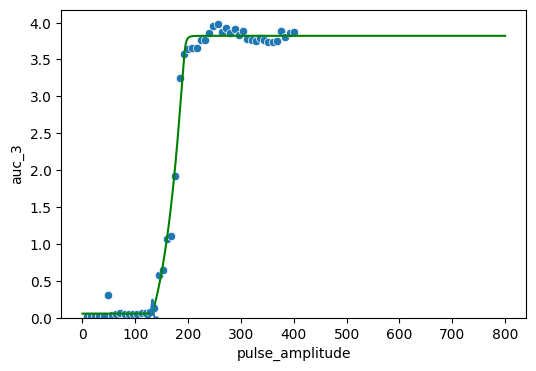

In [17]:
columns = [subject] + FEATURES
idx = df[columns].apply(tuple, axis=1).isin([combination])
temp_df = df[idx].reset_index(drop=True).copy()



plt.figure(figsize=(6, 4))
sns.scatterplot(data=temp_df, x=INTENSITY, y=RESPONSE[0])
# sns.lineplot(x=model.x_space, y=obs_mean_posterior[:, 0], color="red")
sns.lineplot(x=model.x_space, y=mean_mean_posterior[:, 0], color="green")
sns.kdeplot(posterior_samples["a"][:, 0, 0, 0])
# plt.axvline(a)

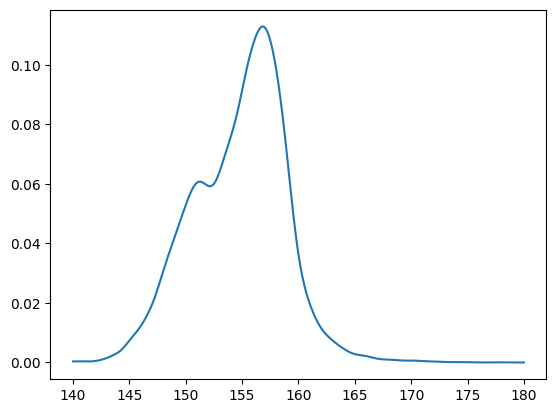

In [153]:
import statsmodels.api as sm

dens = sm.nonparametric.KDEUnivariate(posterior_samples["a"][:, 0, 0, 0])
dens.fit()
x =np.linspace(140,180,1000) #restrict range to (0,1)
y = dens.evaluate(x)
plt.plot(x,y)

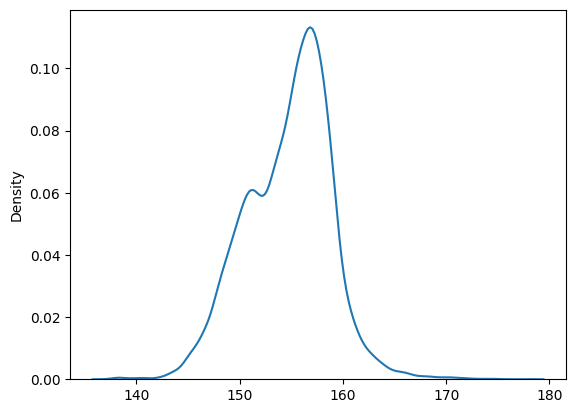

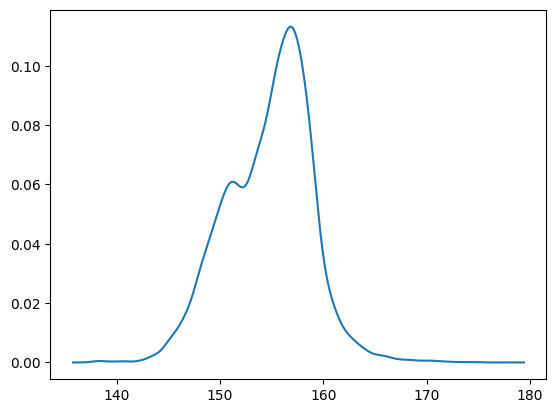

In [145]:
my_data = posterior_samples["a"][:, 0, 0, 0]
my_kde = sns.kdeplot(my_data)
line = my_kde.lines[0]
x, y = line.get_data()

fig, ax = plt.subplots()
ax.plot(x[x>0], y[x>0])

In [143]:
posterior_samples["a"][:, 0, 0, 0]

(24000,)

<Axes: xlabel='pulse_amplitude', ylabel='auc_3'>

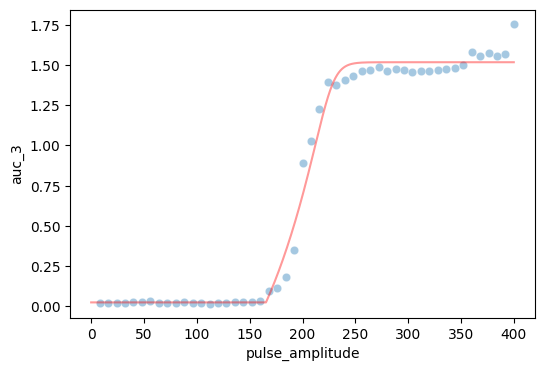

In [55]:
a = np.array(posterior_samples["a"].mean()).tolist()
b = np.array(posterior_samples["b"].mean()).tolist()
lo = np.array(posterior_samples["lo"].mean()).tolist()
h = np.array(posterior_samples["h"].mean()).tolist()
v = np.array(posterior_samples["v"].mean()).tolist()

x_space = np.arange(0, ceil(df[INTENSITY].max(), 20), .1)

y_space = \
    lo + \
    jnp.maximum(
        0,
        -1 + \
        (h + 1) / \
        jnp.power(
            1 + \
            (jnp.power(1 + h, v) - 1) * \
            jnp.exp(-b * (x_space - a)),
            1 / v
        )
    )

plt.figure(figsize=(6, 4))

sns.lineplot(x=x_space, y=y_space, color="red", alpha=.4)
sns.scatterplot(data=df, x=INTENSITY, y=RESPONSE[0], alpha=.4)


In [42]:
x_space.shape

(4000,)

<Axes: xlabel='pulse_amplitude', ylabel='auc_3'>

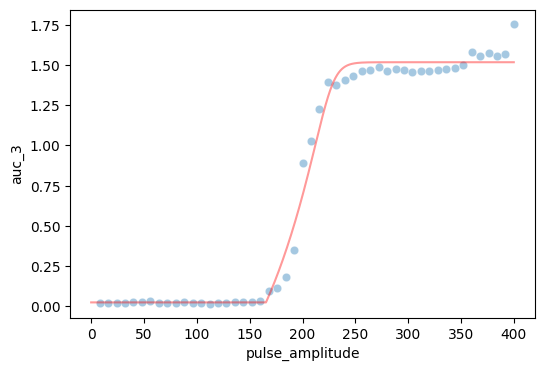

In [25]:
y_space

Array([0.02530997, 0.02530997, 0.02530997, ..., 1.51684676, 1.51684676,
       1.51684676], dtype=float64)

2023-06-30 16:18:30,111 - hb_mep.utils.utils - INFO - func:predictive_check took: 26.77 sec


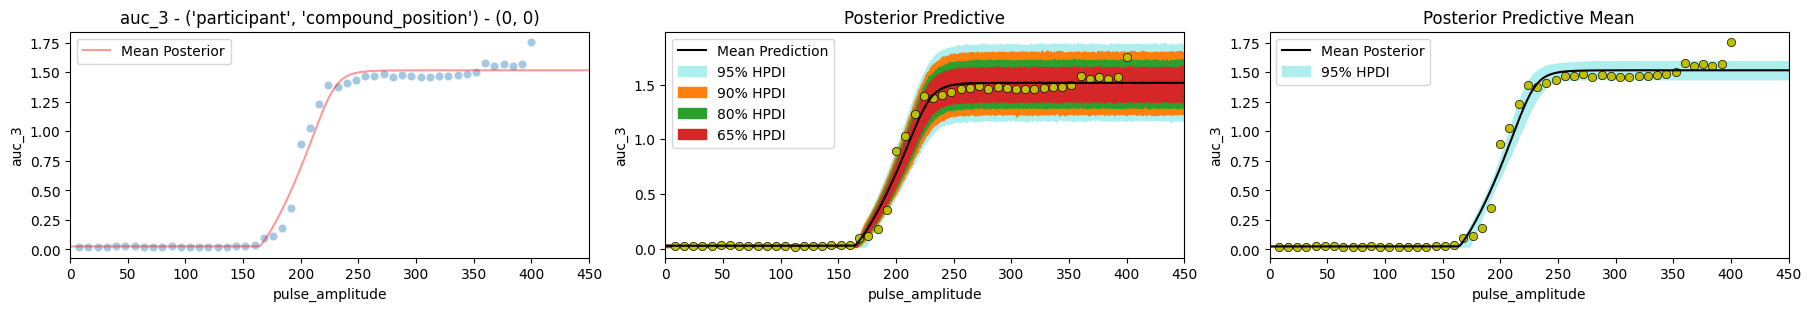

In [28]:
predictive_check(model, df, posterior_samples);